# Final Project Rough Draft

## Introduction

### Background and Data
Pulsars radiate two rotating narrow beams of light in different directions at regular rapid intervals (Cofield, 2016). The beams of light spin and sweep across the sky instead of pointing in a single direction because they are not aligned with the pulsar's axis of rotation (Cofield, 2016). From earth, pulsars appear to be flickering stars, despite the light from the beams being steady because of the spinning that occurs. Pulsars are around the size of a city and are believed to be neutron stars, meaning they form when a star’s core collapses upon itself in a supernova (Hobbs, 2020). 


We are using the Predicting Pulsar Star dataset retrieved from Kaggle. Each observation in the dataset contains the mean, standard deviation, skewness, excess kurtosis of the integrated profile and DM-SNR Curve of each star, and each star’s observed class. The integrated profile of a pulsar is the folded signal array obtained with respect to its rotational period and signal (Liu, 2017). The shape is unique to each pulsar and can be used to distinguish pulsars from one another. The other four are concerning statistics for the DM-SNR Curve. DM-SNR stands for Dispersion Measure (how the signal of a star broadens) of the Signal to Noise Ratio (Swinburne University of Technology, 2020; The University of Sheffield, n.d.). Noise will appear in all astronomical measurements, limiting the precision of a measurement made from data. So, the Signal to Noise ratio (ratio of the signal from an astronomical source to the noise) is calculated in an attempt to estimate the noise in observations to determine if observations will be adequate (The University of Sheffield, n.d.).


<img src="https://scx2.b-cdn.net/gfx/news/hires/pulsar.gif" style="<float: right; height: 20em">
Image Credit: Imagine the Universe! at NASA/GSFC

### Question
How do different 2-D and 4-D KNN models compare for accurately classifying the type of star based on the summary statistics of a star's integrated profile and DM-SNR Curve?

How well does the best variable combination predict if a star is a pulsar?

- Change phrasing: How does the best variable combination predict if a star is a pulsar
- Compare best K's but still on training data
- Clarify question and communication in applied context

First, we read all of the required packages into R. Then, the kaggle data set was read in and assigned a name, and the column names were then shortened into human readable variables.

In [1]:
#Read packages into R
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

#Reading the dataset and shortening the column names
pulsar_base_data = read_csv("https://raw.githubusercontent.com/NicoRui/DSCI_100_Project/main/pulsar_data_train.csv", skip = 1,
                            col_names = c("mean_prof", "sd_prof", 
                                          "kurt_prof", "skew_prof", "mean_DMSNR",
                                          "sd_DMSNR","kurt_DMSNR","skew_DMSNR", "target_class")) %>% 
                    mutate(target_class = as_factor(target_class)) %>% 
                    mutate(target_class = fct_recode(target_class,
                                                    "non_pulsar" = '0',
                                                    "pulsar" = '1')) 
           
head(pulsar_base_data)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121.15625,48.37297,0.3754847,-0.01316549,3.168896,18.39937,7.449874,65.159298,non_pulsar
76.96875,36.17556,0.7128979,3.38871856,2.399666,17.57100,9.414652,102.722975,non_pulsar
130.58594,53.22953,0.1334083,-0.29724164,2.743311,22.36255,8.508364,74.031324,non_pulsar
156.39844,48.86594,-0.2159886,-0.17129365,17.471572,NA,2.958066,7.197842,non_pulsar
84.80469,36.11766,0.8250128,3.27412537,2.790134,20.61801,8.405008,76.291128,non_pulsar
121.00781,47.17694,0.2297081,0.09133623,2.036789,NA,9.546051,112.131721,non_pulsar


A seed was set to ensure that the same result was obtained each time the processes were run. The data was then split into its respective pulsar training data and pulsar testing data.


In [2]:
#Splitting Data
set.seed(632)
pulsar_split = initial_split(pulsar_base_data, prop = 0.8, strata = target_class)
pulsar_train = training(pulsar_split)
pulsar_test = testing(pulsar_split)

#### Table 1 - Training Data

In [3]:
head(pulsar_train)

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121.15625,48.37297,0.3754847,-0.01316549,3.168896,18.39937,7.4498741,65.159298,non_pulsar
76.96875,36.17556,0.7128979,3.38871856,2.399666,17.57100,9.4146523,102.722975,non_pulsar
130.58594,53.22953,0.1334083,-0.29724164,2.743311,22.36255,8.5083638,74.031324,non_pulsar
84.80469,36.11766,0.8250128,3.27412537,2.790134,20.61801,8.4050084,76.291128,non_pulsar
121.00781,47.17694,0.2297081,0.09133623,2.036789,NA,9.5460511,112.131721,non_pulsar
79.34375,42.40217,1.0634129,2.24437669,141.641304,NA,-0.7008088,-1.200653,non_pulsar


#### Table 2 - Testing Data

In [4]:
head(pulsar_test)

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
156.3984,48.86594,-0.21598860,-0.17129365,17.471572,NA,2.958066,7.197842,non_pulsar
83.9375,45.71272,0.74877682,1.34290171,1.747492,12.07058,11.838557,NA,non_pulsar
111.7109,46.57054,0.27286063,-0.06164600,2.139632,16.65571,9.353872,97.733760,non_pulsar
127.3281,45.33954,-0.02866461,-0.20653223,3.955686,26.25178,6.815905,46.623791,non_pulsar
108.7578,47.47084,0.23388338,-0.01183974,3.428930,22.80573,7.431087,58.339075,non_pulsar
117.6797,47.45704,0.21480140,-0.13550329,2.731605,21.99329,8.401669,71.587641,non_pulsar


Since there were several missing values (NAs) within the training and testing datasets, we dropped the rows that contained missing values. We then determined the distributional characteristics of all of the predictor variables.

In [17]:
# Table of some summary statistics for each variable
summary(pulsar_train)

#Pulsar train and test with no NAs
pulsar_train_noNA = drop_na(pulsar_train)
pulsar_test_noNA = drop_na(pulsar_test)

#Distributional Characteristics with no NAs
summary_train_distribution = pulsar_train_noNA %>% 
    group_by(target_class) %>% 
    summarize_all(list(mean = mean, sd = sd)) %>% 
    mutate(across(where(is.numeric), round, 3))

   mean_prof          sd_prof        kurt_prof         skew_prof      
 Min.   :  6.188   Min.   :24.77   Min.   :-1.7380   Min.   :-1.7919  
 1st Qu.:100.625   1st Qu.:42.30   1st Qu.: 0.0230   1st Qu.:-0.1856  
 Median :115.102   Median :46.93   Median : 0.2233   Median : 0.2062  
 Mean   :110.895   Mean   :46.51   Mean   : 0.4859   Mean   : 1.8416  
 3rd Qu.:127.203   3rd Qu.:51.02   3rd Qu.: 0.4769   3rd Qu.: 0.9523  
 Max.   :189.734   Max.   :91.81   Max.   : 8.0695   Max.   :68.1016  
                                   NA's   :1410                       
   mean_DMSNR          sd_DMSNR        kurt_DMSNR       skew_DMSNR      
 Min.   :  0.2132   Min.   :  7.37   Min.   :-3.139   Min.   :  -1.945  
 1st Qu.:  1.9122   1st Qu.: 14.40   1st Qu.: 5.815   1st Qu.:  35.208  
 Median :  2.7860   Median : 18.44   Median : 8.465   Median :  83.310  
 Mean   : 12.9438   Mean   : 26.43   Mean   : 8.341   Mean   : 106.211  
 3rd Qu.:  5.3955   3rd Qu.: 28.33   3rd Qu.:10.728   3rd Qu.: 140.

#### Table 3 - Distributional Characteristics

In [18]:
head(summary_train_distribution)

target_class,mean_prof_mean,sd_prof_mean,kurt_prof_mean,skew_prof_mean,mean_DMSNR_mean,sd_DMSNR_mean,kurt_DMSNR_mean,skew_DMSNR_mean,mean_prof_sd,sd_prof_sd,kurt_prof_sd,skew_prof_sd,mean_DMSNR_sd,sd_DMSNR_sd,kurt_DMSNR_sd,skew_DMSNR_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
non_pulsar,116.716,47.316,0.209,0.388,8.970,23.246,8.914,115.468,17.586,6.156,0.335,0.998,24.857,16.744,4.313,110.374
pulsar,56.086,38.607,3.179,16.080,51.245,56.557,2.765,18.455,30.094,8.157,1.921,14.615,46.618,20.025,3.155,48.350


All of the predictor variables were standardized and upsampled.  Standardization was used to ensure variables using different scales would not be weighted in accordance to the size of the scale (i.e. a large-scale variable dominates the euclidean distance).  Upsampling was used to remove the class imbalance, which was roughly nine-to-one.


In [108]:
#Standardization of all predictor variables

pulsar_train_upsample_recipe = recipe(target_class~., data = pulsar_train_noNA) %>% 
        step_upsample(target_class, over_ratio = 1, skip = FALSE) %>% 
        prep()
pulsar_train_upsample = bake(pulsar_train_upsample_recipe, pulsar_train_noNA)

pulsar_recipe_train = recipe(target_class~., data = pulsar_train_upsample) %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors()) %>% 
                    prep()
scaled_pulsar_train = bake(pulsar_recipe_train, pulsar_train_upsample)


pulsar_recipe_test = recipe(target_class~., data = pulsar_test_noNA) %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors()) %>% 
                    prep()
scaled_pulsar_test = bake(pulsar_recipe_test, pulsar_test_noNA)

#### Table 4 - Original Target Class 

In [109]:
head(group_by(pulsar_train_noNA, target_class) %>% summarize(n = n()))

`summarise()` ungrouping output (override with `.groups` argument)



target_class,n
<fct>,<int>
non_pulsar,6711
pulsar,691


#### Table 5 - Upsampled Target Class

In [110]:
head(group_by(scaled_pulsar_train, target_class) %>% summarize(n = n()))

`summarise()` ungrouping output (override with `.groups` argument)



target_class,n
<fct>,<int>
non_pulsar,6711
pulsar,6711


#### Table 6 - Scaled Pulsar Training Data

In [111]:
head(scaled_pulsar_train)

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.88776418,0.6301074,-0.6455580,-0.6285771,-0.6237392,-0.8601776,0.3253810,-0.02204699,non_pulsar
-0.24975562,-0.8142870,-0.4775190,-0.3640204,-0.6416596,-0.8935839,0.7284513,0.36094689,non_pulsar
1.13051284,1.2052121,-0.7661172,-0.6506691,-0.6336539,-0.7003515,0.5425280,0.06841093,non_pulsar
-0.04803491,-0.8211431,-0.4216834,-0.3729321,-0.6325631,-0.7707049,0.5213249,0.09145156,non_pulsar
0.58528367,1.5229263,-0.5511225,-0.6231791,-0.6323878,-0.8159317,0.7343246,0.30641541,non_pulsar
0.21462437,-0.3353748,-0.6594560,-0.5378743,-0.6330306,-0.8675022,0.4077132,0.03548456,non_pulsar


Four 2-D scatter plots were created using the standardized training data, and each plot contained either the mean, standard deviation, kurtosis, and skewness variables of the integrated profiles plotted against those of the DM-SNR curve. The blue data points represent non-pulsars, while the red represents the pulsars.



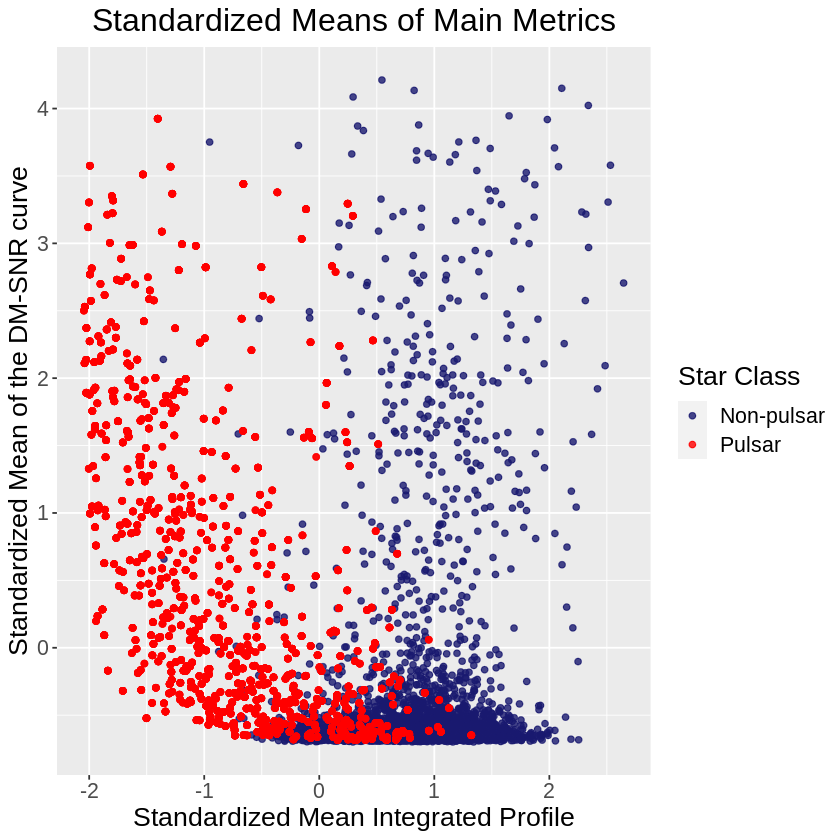

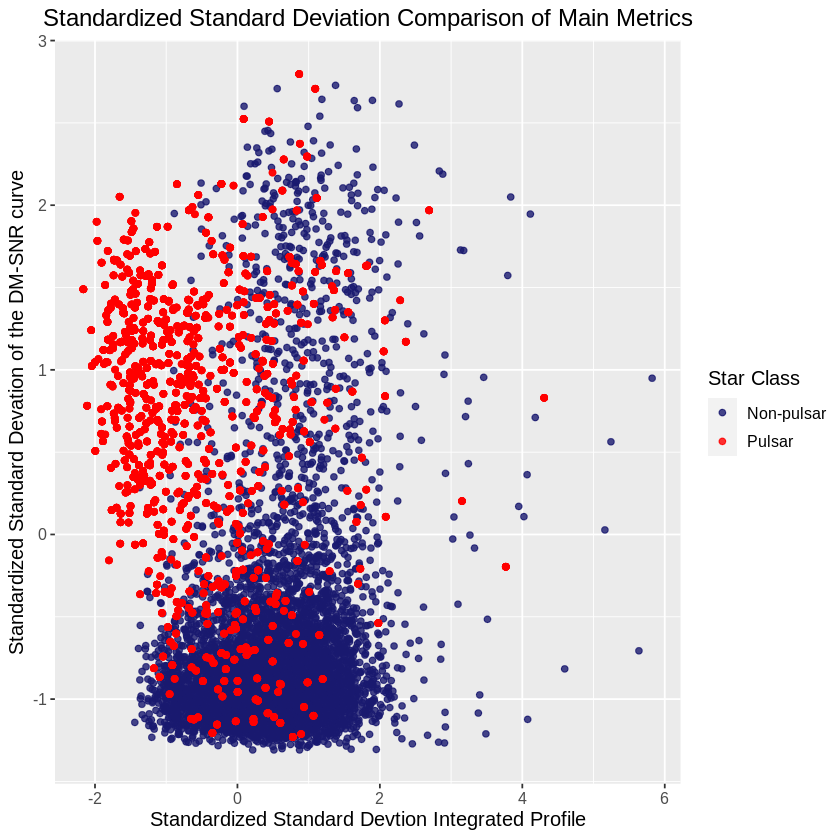

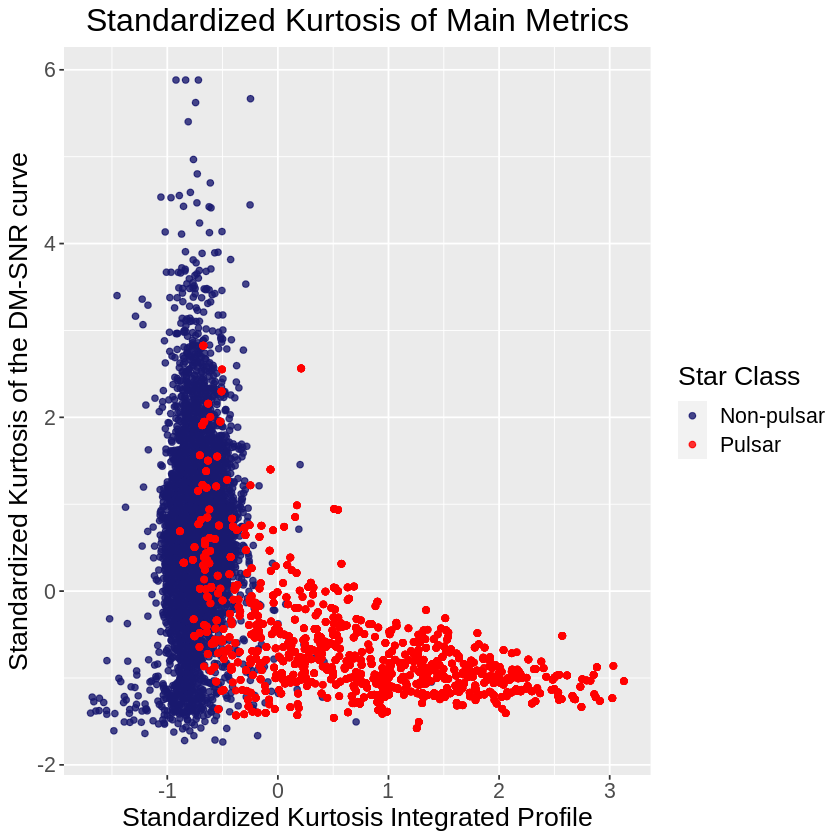

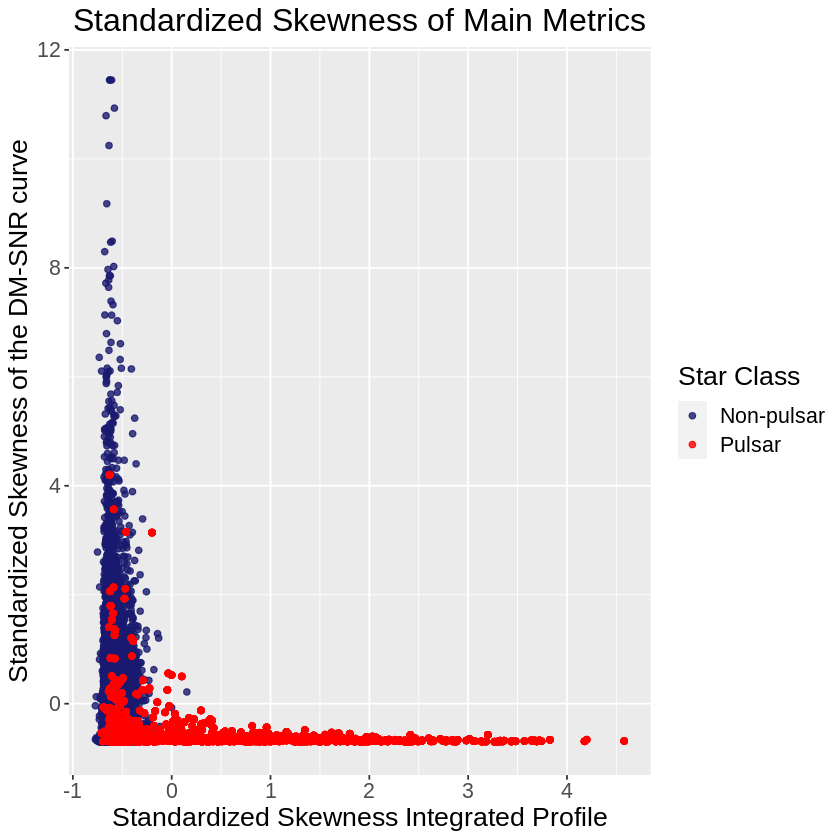

In [21]:
#Visualization for each 2-D pairing, as shown in class
mean_scaled_vis = ggplot(scaled_pulsar_train, aes(x = mean_prof, y = mean_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Mean Integrated Profile", y = "Standardized Mean of the DM-SNR curve",
           color = "Star Class", title = "Standardized Means of Main Metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
mean_scaled_vis

sd_scaled_vis = ggplot(scaled_pulsar_train, aes(x = sd_prof, y = sd_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Standard Devtion Integrated Profile",
         y = "Standardized Standard Devation of the DM-SNR curve",
           color = "Star Class", 
         title = "Standardized Standard Deviation Comparison of Main Metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 12), plot.title = element_text(hjust = 0.5))
sd_scaled_vis

kurt_scaled_vis = ggplot(scaled_pulsar_train, aes(x = kurt_prof, y = kurt_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Kurtosis Integrated Profile",
         y = "Standardized Kurtosis of the DM-SNR curve",
           color = "Star Class", title = "Standardized Kurtosis of Main Metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
kurt_scaled_vis

skew_scaled_vis = ggplot(scaled_pulsar_train, aes(x = skew_prof, y = skew_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Skewness Integrated Profile",
         y = "Standardized Skewness of the DM-SNR curve",
           color = "Star Class", title = "Standardized Skewness of Main Metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
skew_scaled_vis

## Models
### Means Model

We created a scaled recipe to predict the target class based on the mean of the integrated profile and DM-SNR curve. 
The seed was randomly selected to be 781. For each of these different sets of variables, we created a K-nearest-neighbours model on the training set.  Five-fold-cross-validation was used to tune the hyperparameter K across the values 1 to 20. 



In [23]:
mean_recipe_train <-recipe(target_class~mean_prof+mean_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_mean_train <- bake(mean_recipe_train, scaled_pulsar_train)

mean_recipe_test <- recipe(target_class~ mean_prof + mean_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_mean_test <- bake(mean_recipe_train, scaled_pulsar_test)
set.seed(781)
gridvals = tibble(neighbors = seq(1,20))
mean_vfold <- vfold_cv(scaled_mean_train, v = 5, strata = target_class)
knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification") 

##### Table 7 - Scaled Mean Training Data

In [36]:
head(scaled_mean_train)

mean_prof,mean_DMSNR,target_class
<dbl>,<dbl>,<fct>
0.89262319,-0.6302357,non_pulsar
-0.23681405,-0.6480747,non_pulsar
1.13364702,-0.6401053,non_pulsar
-0.03652665,-0.6390194,non_pulsar
0.59229193,-0.6388449,non_pulsar
0.22426633,-0.6394848,non_pulsar


#### Table 8 - Scaled Mean Testing Data

In [37]:
head(scaled_mean_test)

mean_prof,mean_DMSNR,target_class
<dbl>,<dbl>,<fct>
0.01107067,-0.3549535,non_pulsar
0.65083778,-0.2897149,non_pulsar
-0.10990580,-0.3086377,non_pulsar
0.25558396,-0.3336879,non_pulsar
-0.64565876,-0.3022701,non_pulsar
0.13876806,-0.2371817,non_pulsar


In [38]:
set.seed(781)
mean_fit <- workflow()%>%
add_recipe(mean_recipe_train)%>%
add_model(knn_spec)%>%
tune_grid(resamples = mean_vfold, grid = gridvals)%>%
collect_metrics()

A KNN accuracy plot was visualized to display the accuracy of the mean predictor at each value of K.  This was done to find the best K value.


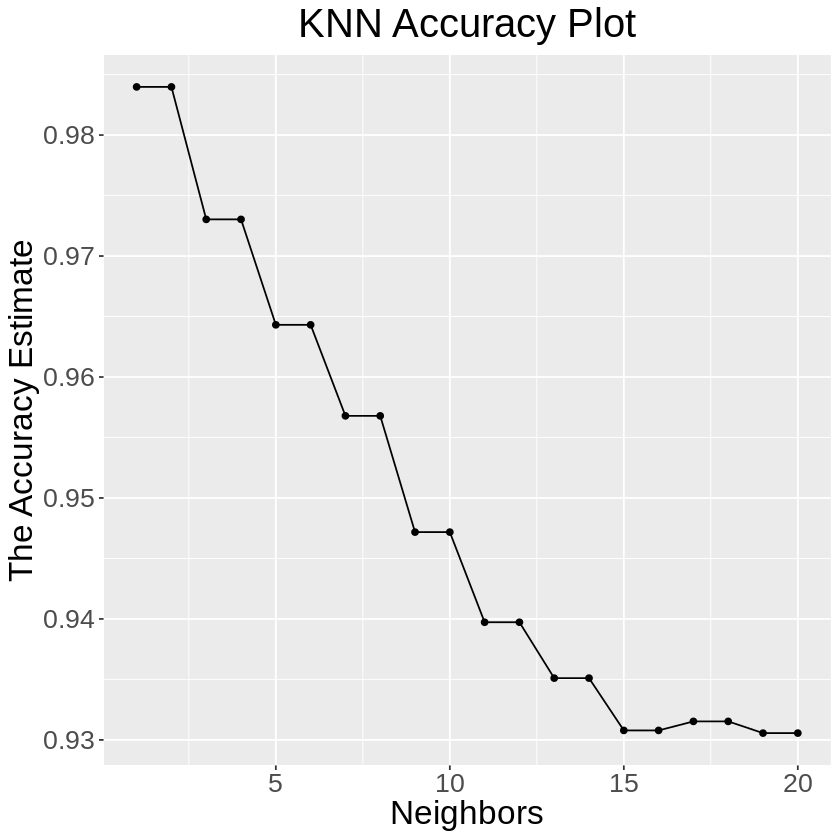

In [39]:
meanFitAccuracy <- filter(mean_fit, .metric == "accuracy")

accuracy_plot_mean <- ggplot(meanFitAccuracy, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "The Accuracy Estimate", title = "KNN Accuracy Plot")+
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
accuracy_plot_mean

BestKaccuracyMean <- meanFitAccuracy %>%
    arrange(desc(mean))%>%
    slice(1)
#BestKaccuracyMean

### Standard Deviation Model

We created a scaled recipe to predict the target class based on the standard deviation of the integrated profile and DM-SNR curve. 
The seed was randomly selected to be 781. For each of these different sets of variables, we created a K-nearest-neighbours model on the training set.  Five-fold-cross-validation was used to tune the hyperparameter K across the values 1 to 20. 

In [42]:
sd_recipe_train = recipe(target_class ~ sd_prof + sd_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_sd_train = bake(sd_recipe_train, scaled_pulsar_train)

sd_recipe_test = recipe(target_class ~ sd_prof + sd_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_sd_test = bake(sd_recipe_test, scaled_pulsar_test)

set.seed(781)
sd_vfold = vfold_cv(scaled_sd_train, v = 5, strata = target_class)   

#### Table 9 - Scaled SD Training Data 

In [43]:
head(scaled_sd_train)

sd_prof,sd_DMSNR,target_class
<dbl>,<dbl>,<fct>
0.6482024,-0.8661958,non_pulsar
-0.8049219,-0.8994441,non_pulsar
1.2267831,-0.7071253,non_pulsar
-0.8118195,-0.7771461,non_pulsar
1.5464175,-0.8221591,non_pulsar
-0.3231152,-0.8734857,non_pulsar


#### Table 10 - Scaled SD Testing Data

In [44]:
head(scaled_sd_test)

sd_prof,sd_DMSNR,target_class
<dbl>,<dbl>,<fct>
0.002139272,-0.498483074,non_pulsar
-0.187662501,0.001776142,non_pulsar
0.140952188,-0.177872560,non_pulsar
0.138825140,-0.220226313,non_pulsar
-0.885023856,-0.259193888,non_pulsar
0.430033563,0.157397274,non_pulsar


In [45]:
set.seed(781)
sd_fit = workflow() %>% 
    add_recipe(sd_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = sd_vfold, grid = gridvals) %>% 
    collect_metrics() 

A KNN accuracy plot was visualized to display the accuracy of the standard deviation predictor at each value of K.  This was done to find the best K value.


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9771268,5,0.001526325,Model01


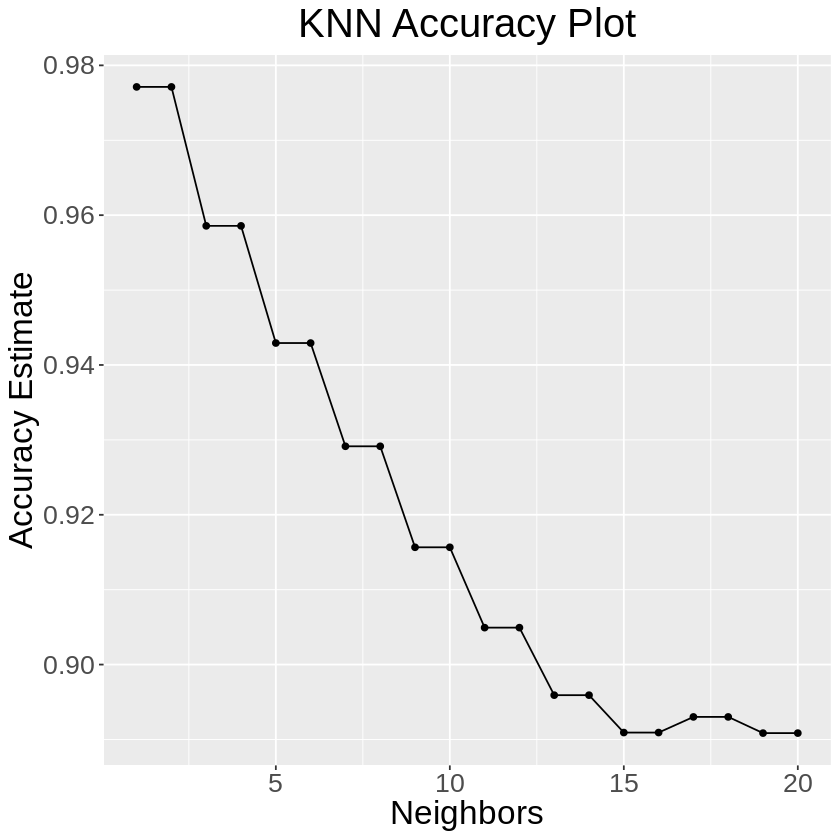

In [46]:
sdFitAccuracy = filter(sd_fit, .metric == "accuracy")

ACC_plot_SD = ggplot(sdFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + 
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot_SD

BestKaccuracySD <- sdFitAccuracy %>%
    arrange(desc(mean))%>%
    slice(1)
BestKaccuracySD

### Skewness Model

We created a scaled recipe to predict the target class based on the skewness of the integrated profile and DM-SNR curve. 
The seed was randomly selected to be 781. For each of these different sets of variables, we created a K-nearest-neighbours model on the training set.  Five-fold-cross-validation was used to tune the hyperparameter K across the values 1 to 20. 

In [50]:
skew_recipe_train = recipe(target_class ~ skew_prof + skew_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_skew_train = bake(skew_recipe_train, scaled_pulsar_train)

skew_recipe_test = recipe(target_class ~ skew_prof + skew_DMSNR, data = scaled_pulsar_test) %>%
                    prep()
scaled_skew_test = bake(skew_recipe_test, scaled_pulsar_test)

set.seed(781)
skew_vfold = vfold_cv(scaled_skew_train, v = 5, strata = target_class)

#### Table 11 - Scaled Skewness Training Data

In [51]:
head(scaled_skew_train)

skew_prof,skew_DMSNR,target_class
<dbl>,<dbl>,<fct>
-0.6363894,-0.01888691,non_pulsar
-0.3759321,0.36367948,non_pulsar
-0.6581391,0.07147004,non_pulsar
-0.3847056,0.09448495,non_pulsar
-0.6310750,0.30920886,non_pulsar
-0.5470921,0.03858042,non_pulsar


##### Table 12 - Scaled Skewness Testing Data

In [54]:
head(scaled_skew_test)

skew_prof,skew_DMSNR,target_class
<dbl>,<dbl>,<fct>
-0.28857476,-0.05490509,non_pulsar
-0.31459801,-0.55910137,non_pulsar
-0.27962898,-0.44353091,non_pulsar
-0.30184039,-0.31283473,non_pulsar
-0.01691419,-0.29278131,non_pulsar
-0.33386356,-0.66868236,non_pulsar


In [55]:
set.seed(781)
skew_fit = workflow() %>%
    add_recipe(skew_recipe_train) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = skew_vfold, grid = gridvals) %>%
    collect_metrics()

A KNN accuracy plot was visualized to display the accuracy of the skewness predictor at each value of K.  This was done to find the best K value.


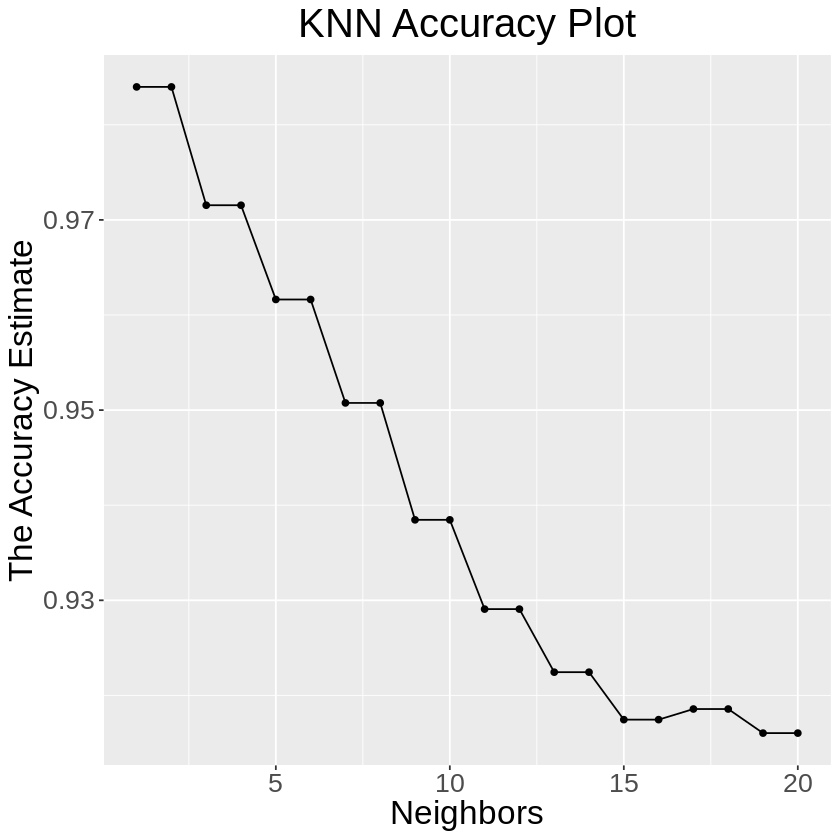

In [56]:
skewFitAccuracy <- filter(skew_fit, .metric == "accuracy")

accuracy_plot_skew <- ggplot(skewFitAccuracy, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "The Accuracy Estimate", title = "KNN Accuracy Plot")+
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
accuracy_plot_skew

In [59]:
BestKaccSkew = skewFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)

#### Table 13 - Best Skewness K Value

In [61]:
head(BestKaccSkew)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9839823,5,0.001473482,Model01


### Kurtosis Model

We created a scaled recipe to predict the target class based on the kurtosis of the integrated profile and DM-SNR curve. 
The seed was randomly selected to be 781. For each of these different sets of variables, we created a K-nearest-neighbours model on the training set.  Five-fold-cross-validation was used to tune the hyperparameter K across the values 1 to 20. 

In [66]:
kurt_recipe_train = recipe(target_class ~ kurt_prof + kurt_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_kurt_train = bake(kurt_recipe_train, scaled_pulsar_train)

kurt_recipe_test = recipe(target_class ~ kurt_prof + kurt_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_kurt_test = bake(kurt_recipe_test, scaled_pulsar_test)

set.seed(781)
kurt_vfold = vfold_cv(scaled_kurt_train, v = 5, strata = target_class)

#### Table 14 - Scaled Kurtosis Training Data

In [67]:
head(scaled_kurt_train)

kurt_prof,kurt_DMSNR,target_class
<dbl>,<dbl>,<fct>
-0.6542233,0.3305659,non_pulsar
-0.4883327,0.7332180,non_pulsar
-0.7732411,0.5474876,non_pulsar
-0.4332109,0.5263064,non_pulsar
-0.5609952,0.7390852,non_pulsar
-0.6679436,0.4128127,non_pulsar


#### Table 15 - Scaled Kurtosis Testing Data

In [68]:
head(scaled_kurt_test)

kurt_prof,kurt_DMSNR,target_class
<dbl>,<dbl>,<fct>
-0.18496543,0.24305640,non_pulsar
-0.49151524,-0.33098399,non_pulsar
-0.22459219,-0.19184137,non_pulsar
-0.24399215,0.02768594,non_pulsar
0.08090689,-0.06350674,non_pulsar
-0.32417289,-0.53718862,non_pulsar


In [69]:
set.seed(781)
kurt_fit = workflow() %>% 
    add_recipe(kurt_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = kurt_vfold, grid = gridvals) %>% 
    collect_metrics()

A KNN accuracy plot was visualized to display the accuracy of the kurtosis predictor at each value of K.  This was done to find the best K value.


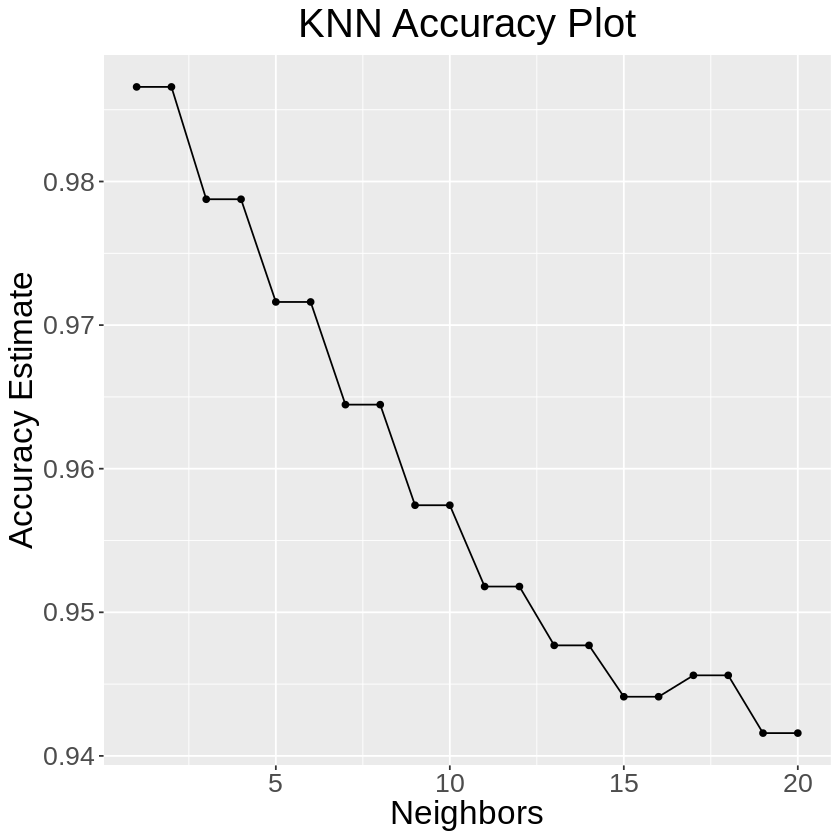

In [72]:
kurtFitAccuracy = filter(kurt_fit, .metric == "accuracy")

ACC_plot_kurt = ggplot(kurtFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot_kurt

In [73]:
BestKaccKurt = kurtFitAccuracy %>%
    arrange(desc(mean)) %>%
    slice(1)

#### Table 16 - Best Kurtosis K Value

In [74]:
head(BestKaccKurt)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.986589,5,0.000677801,Model01


### Integrated Profile Model

We created a scaled recipe to predict the target class of the integrated profile model using 4 predictors (mean, standard deviation, kurtosis and skewness).  The seed was randomly selected to be 781. A 5 fold cross validation was done on the scaled training data.

In [78]:
profile_recipe_train = recipe(target_class ~ mean_prof + sd_prof + kurt_prof + skew_prof, data = scaled_pulsar_train) %>% 
                    prep()
scaled_profile_train = bake(profile_recipe_train, scaled_pulsar_train)

profile_recipe_test = recipe(target_class ~ mean_prof + sd_prof + kurt_prof + skew_prof, data = scaled_pulsar_test) %>% 
                    prep()
scaled_profile_test = bake(profile_recipe_test, scaled_pulsar_test)

set.seed(781)
profile_vfold = vfold_cv(scaled_profile_train, v = 5, strata = target_class)

#### Table 17 - Scaled Integrated Profile Training Data

In [79]:
head(scaled_profile_train)

mean_prof,sd_prof,kurt_prof,skew_prof,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.89262319,0.6482024,-0.6542233,-0.6363894,non_pulsar
-0.23681405,-0.8049219,-0.4883327,-0.3759321,non_pulsar
1.13364702,1.2267831,-0.7732411,-0.6581391,non_pulsar
-0.03652665,-0.8118195,-0.4332109,-0.3847056,non_pulsar
0.59229193,1.5464175,-0.5609952,-0.6310750,non_pulsar
0.22426633,-0.3231152,-0.6679436,-0.5470921,non_pulsar


#### Table 18 - Scaled Integrated Profile Testing Data

In [80]:
head(scaled_profile_test)

mean_prof,sd_prof,kurt_prof,skew_prof,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.01107067,0.002139272,-0.18496543,-0.28857476,non_pulsar
0.65083778,-0.187662501,-0.49151524,-0.31459801,non_pulsar
-0.10990580,0.140952188,-0.22459219,-0.27962898,non_pulsar
0.25558396,0.138825140,-0.24399215,-0.30184039,non_pulsar
-0.64565876,-0.885023856,0.08090689,-0.01691419,non_pulsar
0.13876806,0.430033563,-0.32417289,-0.33386356,non_pulsar


In [81]:
set.seed(781)
profile_fit = workflow() %>% 
    add_recipe(profile_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = profile_vfold, grid = gridvals) %>% 
    collect_metrics()


A KNN accuracy plot was visualized to display the accuracy of the integrated profile at each value of K.  This was done to find the best K value.


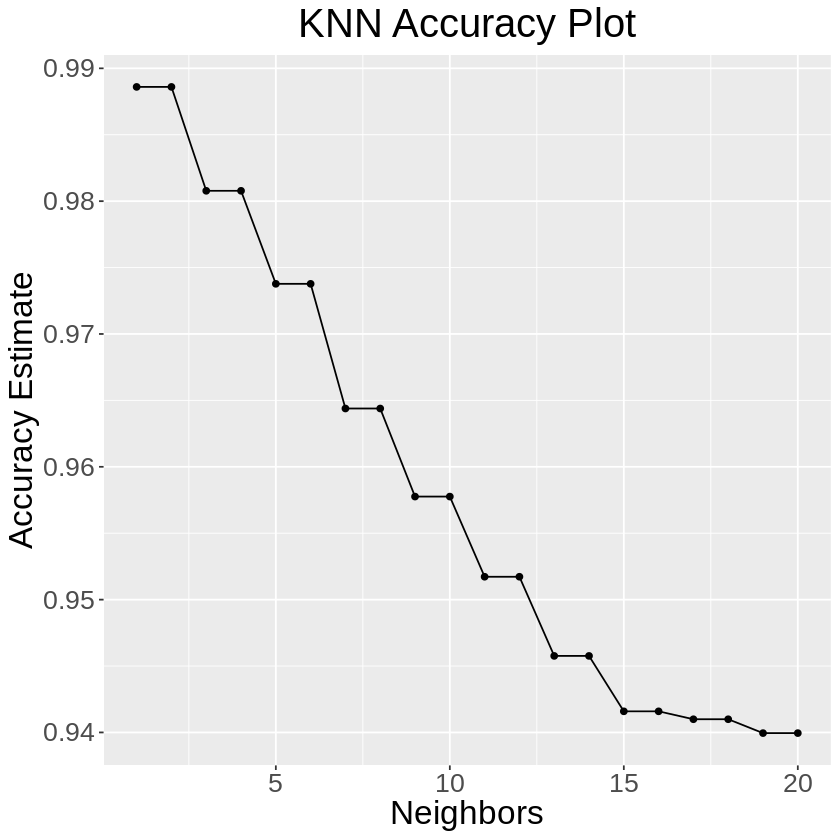

In [86]:
ProfFitAccuracy = filter(profile_fit, .metric == "accuracy")

ACC_plot_prof = ggplot(ProfFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot_prof

In [87]:
BestKaccProf = ProfFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)

#### Table 19 - Best Integrated Profile K Value

In [88]:
head(BestKaccProf)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9886012,5,0.0008024797,Model01


### DMSNR Model

We created a scaled recipe to predict the target class of the DMSNR model using 4 predictors (mean, standard deviation, kurtosis and skewness).  The seed was randomly selected to be 781. A 5 fold cross validation was done on the scaled training data. 


In [92]:
DMSNR_recipe_train = recipe(target_class ~ mean_DMSNR + sd_DMSNR + kurt_DMSNR + skew_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_DMSNR_train = bake(DMSNR_recipe_train, scaled_pulsar_train)

DMSNR_recipe_test = recipe(target_class ~ mean_DMSNR + sd_DMSNR + kurt_DMSNR + skew_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_DMSNR_test = bake(DMSNR_recipe_test, scaled_pulsar_test)

set.seed(781)
DMSNR_vfold = vfold_cv(scaled_DMSNR_train, v = 5, strata = target_class)

#### Table 20 - Scaled DMSNR Training Data

In [93]:
head(scaled_DMSNR_train)

mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.6302357,-0.8661958,0.3305659,-0.01888691,non_pulsar
-0.6480747,-0.8994441,0.7332180,0.36367948,non_pulsar
-0.6401053,-0.7071253,0.5474876,0.07147004,non_pulsar
-0.6390194,-0.7771461,0.5263064,0.09448495,non_pulsar
-0.6388449,-0.8221591,0.7390852,0.30920886,non_pulsar
-0.6394848,-0.8734857,0.4128127,0.03858042,non_pulsar


#### Table 21 - Scaled DMSNR Testing Data

In [94]:
head(scaled_DMSNR_test)

mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.3549535,-0.498483074,0.24305640,-0.05490509,non_pulsar
-0.2897149,0.001776142,-0.33098399,-0.55910137,non_pulsar
-0.3086377,-0.177872560,-0.19184137,-0.44353091,non_pulsar
-0.3336879,-0.220226313,0.02768594,-0.31283473,non_pulsar
-0.3022701,-0.259193888,-0.06350674,-0.29278131,non_pulsar
-0.2371817,0.157397274,-0.53718862,-0.66868236,non_pulsar


In [95]:
set.seed(781)
DMSNR_fit = workflow() %>% 
    add_recipe(DMSNR_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = DMSNR_vfold, grid = gridvals) %>% 
    collect_metrics()


A KNN accuracy plot was visualized to display the accuracy of the DM-SNR model at each value of K.  This was done to find the best K value.


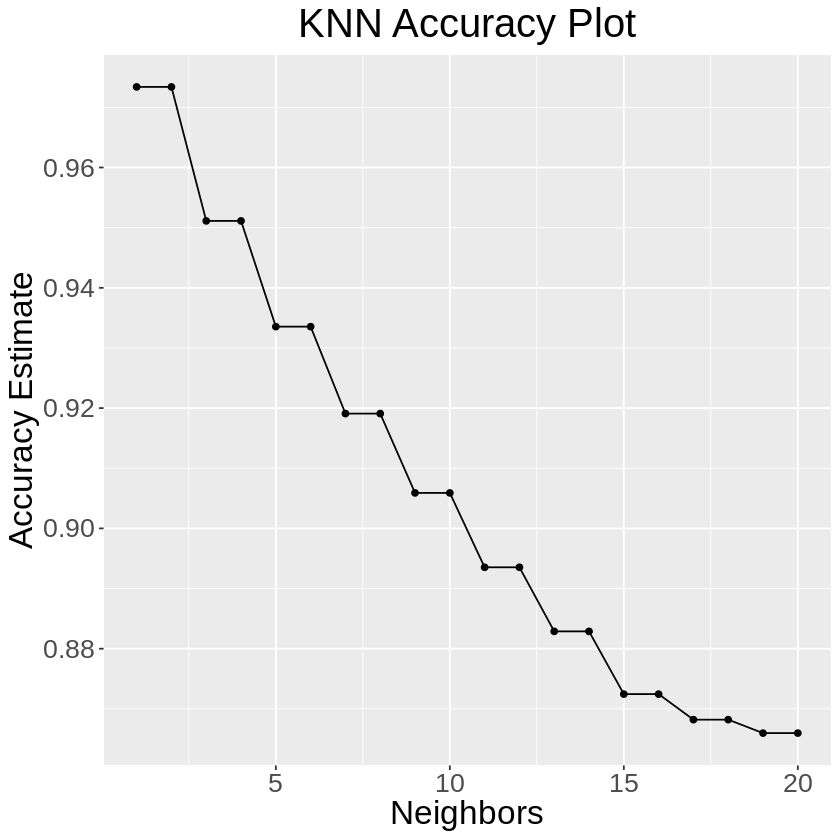

In [99]:
DMSNRFitAccuracy = filter(DMSNR_fit, .metric == "accuracy")

ACC_plot = ggplot(DMSNRFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot

In [100]:
BestKaccDMSNR = DMSNRFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)

#### Table 22 - Best DMSNR K Value

In [101]:
head(BestKaccDMSNR)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9734025,5,0.001383837,Model01


A tibble was created to display the accuracies and best K value on the train set for all of our models. The accuracy was compared in order to select the best group of predictor variables.


In [43]:
TrainAccuracies = tibble(rbind(BestKaccuracyMean, BestKaccuracySD, BestKaccSkew, 
                               BestKaccKurt, BestKaccProf, BestKaccDMSNR))
TrainAccuracies

AlsoBestKurtK = kurtFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(2)
AlsoBestKurtK

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9839072,5,0.0008014114,Model01
1,accuracy,binary,0.9769779,5,0.0015158202,Model01
1,accuracy,binary,0.9838334,5,0.0017067954,Model01
1,accuracy,binary,0.9865890,5,0.0006778010,Model01
1,accuracy,binary,0.9881544,5,0.0011179943,Model01
1,accuracy,binary,0.9730301,5,0.0015618574,Model01


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.986589,5,0.000677801,Model02


In [60]:
kurtFitROC_AUC = filter(kurt_fit, .metric == "roc_auc")
slice(kurtFitROC_AUC, 1:6)

ProfFitROC_AUC = filter(profile_fit, .metric == "roc_auc")
slice(ProfFitROC_AUC, 1:6)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,roc_auc,binary,0.9865890,5,0.0006778010,Model01
2,roc_auc,binary,0.9865890,5,0.0006778010,Model02
3,roc_auc,binary,0.9865843,5,0.0007147932,Model03
4,roc_auc,binary,0.9866539,5,0.0005946706,Model04
5,roc_auc,binary,0.9869677,5,0.0006150943,Model05
6,roc_auc,binary,0.9874165,5,0.0007569543,Model06


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,roc_auc,binary,0.9881544,5,0.0011179943,Model01
2,roc_auc,binary,0.9883651,5,0.0009231399,Model02
3,roc_auc,binary,0.9886880,5,0.0008766631,Model03
4,roc_auc,binary,0.9886648,5,0.0008531857,Model04
5,roc_auc,binary,0.9891112,5,0.0008439891,Model05
6,roc_auc,binary,0.9895193,5,0.0010193926,Model06


## Performance on the test set

Comparing the accuracies of the best K values of the, we see that $k=1$ for all of the model's best accuracies

******** not done yet :
We then ran the best group of predictor variables on the testing data set to see how good the model actually is.

In [73]:
## using kurt_recipe_train
knn_spec_best = nearest_neighbor(weight_func = "rectangular", neighbors = 1) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

In [74]:
kurt_best_fit = workflow() %>% 
    add_recipe(kurt_recipe_train) %>% 
    add_model(knn_spec_best) %>%
    fit(data = scaled_kurt_train)

In [75]:
kurt_pulsar_preds = predict(kurt_best_fit, scaled_pulsar_test) %>% 
    bind_cols(scaled_pulsar_test) %>% 
    select(kurt_prof, kurt_DMSNR, target_class, .pred_class)
kurt_pulsar_preds

kurt_pulsar_predmetrics = metrics(kurt_pulsar_preds, truth = target_class, estimate = .pred_class)
kurt_pulsar_predmetrics
kurt_pulsar_conf_mat = conf_mat(kurt_pulsar_preds, truth = target_class, estimate = .pred_class)
kurt_pulsar_conf_mat

kurt_prof,kurt_DMSNR,target_class,.pred_class
<dbl>,<dbl>,<fct>,<fct>
-0.1849654,0.2430564,non_pulsar,pulsar
-0.4915152,-0.3309840,non_pulsar,non_pulsar
-0.2245922,-0.1918414,non_pulsar,non_pulsar
⋮,⋮,⋮,⋮
-0.315980731,-0.004207986,non_pulsar,non_pulsar
-0.058954640,-1.385316266,non_pulsar,pulsar
-0.005908784,-0.208208936,non_pulsar,non_pulsar


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6119722
kap,binary,0.1752835


            Truth
Prediction   non_pulsar pulsar
  non_pulsar        994      8
  pulsar            718    151

Note **The following code does not work yet**

In [78]:
# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(pulsar_test_noNA$kurt_prof), max(pulsar_test_noNA$kurt_prof), length.out = 100)
smo_grid <- seq(min(pulsar_test_noNA$kurt_DMSNR), max(pulsar_test_noNA$kurt_DMSNR), length.out = 100)
asgrid <- as_tibble(expand.grid(Area = are_grid, Smoothness = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(kurt_best_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% rename(Class = .pred_class)

# plot:
# 1. the coloured scatter of the original data
# 2. the faded coloured scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = pulsar_test_noNA, mapping = aes(x = kurt_prof, y = kurt_DMSNR, color = Class), alpha = 0.75) +
  geom_point(data = prediction_table, mapping = aes(x = kurt_prof, y = kurt_DMSNR, color = Class), alpha = 0.02, size = 5.) +
  labs(x = "Kurtosis of Integrated Profile",
         y = "Kurtosis of the DM-SNR curve",
           color = "Star Class", title = "Kurtosis Prediction Areas") +
  scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))

ERROR: Error: The following required columns are missing: 'kurt_prof', 'kurt_DMSNR'.


## References

Cofield, C. (2016, April 22). What Are Pulsars? Space.com. 
https://www.space.com/32661-pulsars.html. 

Eatough, R. P., Molkenthin, N., Kramer, M., Noutsos, A., Keith, M. J., Stappers, B. W., & 
Lyne, A. G. (2010). Selection of radio pulsar candidates using artificial neural networks. Monthly Notices of the Royal Astronomical Society, 407(4), 2443–2450. https://doi.org/10.1111/j.1365-2966.2010.17=

Hobbs, M. (2020, November 17). An Introduction to Pulsars. Australia Telescope National 
Facility. https://www.atnf.csiro.au/outreach/education/everyone/pulsars/index.html.

Liu, K. (2017, June 26). Introduction to Pulsar, Pulsar Timing, and measuring of Pulse Time-of-Arrivals. Personal Collection of Kuo Liu, CIEP, Sèvres, France. 

Lounge, C.-learning. (2020, August 26). Predicting Pulsar Star. Kaggle. 
https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate?select=pulsar_data_train.csv. 

Rowan, L., & Coontz, R. (2004, April 23). The Strange and Twisted World of Pulsars. 
Science. https://science.sciencemag.org/content/304/5670/531.  

Lyon, R. (2017, February 14). HTRU2 Data Set. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/HTRU2

Swinburne University of Technology. (2020). Pulsar Dispersion Measure. COSMOS. https://astronomy.swin.edu.au/cosmos/p/pulsar+dispersion+measure

The University of Sheffield. (n.d.). L14 Signal-to-Noise. PHY217 Observational Techniques for Astronomers. http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/instruments/L14/index.html